# CountMatch Matcher Development
## Part 2: Reproducing Arman's 2011 Mean Absolute Error

This notebook investigates why our prototype in Part 1 produces a much noisier ground truth vs. predictions plot, and much worse mean absolute error.  Originally we were going to look at 2011, but 2010 has many more actual AADT estimates.

## Preprocess Data

These cells are copied from Part 1

In [1]:
%matplotlib inline
import sys
sys.path.append('../')
import importlib
import matplotlib.pyplot as plt
import numpy as np
import knowyourdata as kyd

import pandas as pd
from traffic_prophet import cfg
import pathlib, os
import configparser

import sklearn.metrics as sklm

from traffic_prophet import connection
from traffic_prophet.countmatch import reader
from traffic_prophet.countmatch import growthfactor as gf
from traffic_prophet.countmatch import neighbour

defaultcolours = plt.rcParams['axes.prop_cycle'].by_key()['color']

filepath = pathlib.Path.home().joinpath('.charlesconfig')
if os.path.isfile(filepath):
    vol_conn = connection.Connection(filepath, 'POSTGRES',
                                     'czhu.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'POSTGRES',
                                    'czhu.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['MAPBOX']['token']
    PLOTLY_USER = config['PLOTLY']['user']
    PLOTLY_KEY = config['PLOTLY']['key']
else:
    filepath = pathlib.Path.home().joinpath('cf.txt')
    vol_conn = connection.Connection(filepath, 'localpg',
                                     'prj_vol.btp_centreline_daily_counts')
    ll_conn = connection.Connection(filepath, 'localpg',
                                    'gis.btp_centreline_lonlat')
    config = configparser.RawConfigParser()
    config.read(filepath.as_posix())
    MAPBOX_TOKEN = config['mapbox']['token']
    PLOTLY_USER = config['plotly']['user']
    PLOTLY_KEY = config['plotly']['key']

In [2]:
rdr = reader.Reader(vol_conn)
%time rdr.read()

CPU times: user 1min 39s, sys: 1.77 s, total: 1min 40s
Wall time: 1min 50s


In [3]:
gf.get_growth_factors(rdr)

In [4]:
ptc_ids = np.unique(np.abs(list(rdr.ptcs.keys())))
nb = neighbour.NeighbourLonLatEuclidean(ll_conn, 20, ptc_ids)
%time nb.find_neighbours()

CPU times: user 19.6 s, sys: 344 ms, total: 20 s
Wall time: 19.9 s


In [5]:
def nanaverage(x, axis=None, weights=None):
    if weights is None:
        return np.nanmean(x)
    notnull = ~(np.isnan(x) | np.isnan(weights))
    return np.average(x[notnull], axis=axis, weights=weights[notnull])

def mse_preprocess_ptc_loop(p):
    available_years = p.data['Daily Count'].index.levels[0].values

    # Get ratio between AADT and daily count
    doyr = p.data['Daily Count'].loc[:, ['Date']].copy()
    for year in available_years:
        doyr.loc[year, 'Day-to-AADT Ratio'] = (
            p.data['AADT'].at[year, 'AADT'] /
            p.data['Daily Count'].loc[year, 'Daily Count']).values
    doyr.reset_index(inplace=True)
    doyr['Month'] = doyr['Date'].dt.month
    doyr['Day of Week'] = doyr['Date'].dt.dayofweek
    
    # Number of days of the week in each year and month.  Fill NaNs with
    # 0.
    N_days = (doyr.reset_index()
              .groupby(['Year', 'Month', 'Day of Week'])['Day-to-AADT Ratio']
              .count().unstack(fill_value=0.))

    # Create two arrays - first breaks down values by day-of-week and year.
    # First, get day-to-AADT ratios for each day of week and year.
    ptc_mse_ydow = pd.DataFrame(
        doyr.groupby(['Day of Week', 'Year'])['Day-to-AADT Ratio'].mean())

    # Then, for each day-of-week, calculate MADT, DoMADT, etc. averages
    # weighted by number of days-of-the-week available in the month.
    madt_avg = []
    dom_avg = []
    domadt_avg = []
    for dow, year in ptc_mse_ydow.index:
        # Double loc is shortest way I've discovered to get single-index
        # series.
        weights = N_days.loc[year, :].loc[:, dow]

        madt_avg.append(np.average(
            p.data['MADT'].loc[year, 'MADT'][weights.index].values,
            weights=weights.values))
        dom_avg.append(nanaverage(
            p.data['DoM Factor'].loc[year, :].loc[weights.index, dow],
            weights=weights.values))
        domadt_avg.append(nanaverage(
            p.data['DoMADT'].loc[year, :].loc[weights.index, dow],
            weights=weights.values))
        
    ptc_mse_ydow['MADT Avg.'] = madt_avg
    ptc_mse_ydow['DoM Factor Avg.'] = dom_avg
    ptc_mse_ydow['DoMADT Avg.'] = domadt_avg
    
    if (ptc_mse_ydow['MADT Avg.'].isnull().values.any() or
            ptc_mse_ydow['DoM Factor Avg.'].isnull().values.any() or
            ptc_mse_ydow['DoM Factor Avg.'].isnull().values.any()):
        raise ValueError("yeah, you shouldn't be getting nulls for ydow tables.")

    # Now, create a second array that breaks down the same values but only
    # by year.
    ptc_mse_yo = pd.DataFrame(doyr.groupby('Year')['Day-to-AADT Ratio'].mean())

    madt_avg = []
    dom_avg = []
    domadt_avg = []
    for year in ptc_mse_yo.index:
        n_days_year = N_days.loc[year, :]
        madt_weights = n_days_year.sum(axis=1, skipna=True)

        madt_avg.append(np.average(
            p.data['MADT'].loc[year, 'MADT'][madt_weights.index].values,
            weights=madt_weights.values))

        dom_year = p.data['DoM Factor'].loc[year, :]
        dom_avg.append(nanaverage(
            dom_year.values, weights=n_days_year.values))
        domadt_avg.append(nanaverage(
            p.data['DoMADT'].loc[year, :].values, weights=n_days_year.values))

    ptc_mse_yo['MADT Avg.'] = madt_avg
    ptc_mse_yo['DoM Factor Avg.'] = dom_avg
    ptc_mse_yo['DoMADT Avg.'] = domadt_avg

    if (ptc_mse_yo['MADT Avg.'].isnull().values.any() or
            ptc_mse_yo['DoM Factor Avg.'].isnull().values.any() or
            ptc_mse_yo['DoM Factor Avg.'].isnull().values.any()):
        raise ValueError("yeah, you shouldn't be getting nulls for yo tables.")

    return doyr, ptc_mse_ydow, ptc_mse_yo

def mse_preprocess_ptcs(ptcs):
    for p in ptcs.values():
        doyr, ptc_mse_ydow, ptc_mse_yo = mse_preprocess_ptc_loop(p)
        p.mse_pp = {
            'Day-to-AADT': doyr,
            'MSE_yDoW': ptc_mse_ydow,
            'MSE_y': ptc_mse_yo
        }

In [6]:
%time mse_preprocess_ptcs(rdr.ptcs)

CPU times: user 12.1 s, sys: 46.9 ms, total: 12.1 s
Wall time: 12.1 s


In [7]:
def get_normalized_seasonal_patterns(tcs, rptcs, want_year):
    """Get normalized seasonal patterns for `tcs`.

    For STTCs, get best estimate normalized patterns and corresponding PTC
    normalized patterns to check for MSE (Eqn. 6 in Bagheri).  For PTCs, get
    best estimate from nearby PTCs and check as a part of validation.
    """
    growth_rate_citywide = np.mean([v.growth_factor for v in rptcs.values()])

    for tc in tcs.values():
        # Find neighbouring PTCs by first finding neighbouring centreline IDs,
        # then checking if either direction exists in rptcs.
        neighbours, distances = nb.get_neighbours(tc.centreline_id)
        
        # We can consider both directions if we want, but this is supposed
        # to emulate PRTCS.
#         neighbour_ptcs = [rptcs[n] for n in
#                           [-nbrs for nbrs in neighbours] + neighbours
#                           if n in rptcs.keys()]
        neighbour_ptcs = [rptcs[n] for n in
                          [tc.direction * nbrs for nbrs in neighbours]
                          if n in rptcs.keys()][:5]

        if len(neighbour_ptcs) != 5:
            raise ValueError("selected a weird number of PTC locations!")

        # Declare the columns in the final saved data frame.
        tc_year = []
        tc_dayofyear = []
        tc_ptcid = []
        tc_day_to_aadt_ratio_avg = []
        tc_madt_avg = []
        tc_dom_avg = []
        tc_domadt_avg = []
        tc_closest_year = []
        tc_aadt_closest_year = []

        if tc.is_permanent:
            tc_dc = tc.data['Daily Count'].reset_index()
        else:
            tc_dc = tc.data.reset_index()
        tc_dc['Day of Week'] = tc_dc['Date'].dt.dayofweek

        for i, row in tc_dc.iterrows():
            ryear, rdow = row['Year'], row['Day of Week']

            for p in neighbour_ptcs:

                if rdow in p.mse_pp['MSE_yDoW'].index.levels[0]:
                    unique_years = p.mse_pp['MSE_yDoW'].loc[rdow].index.values
                    closest_year = unique_years[np.argmin(
                        np.abs(unique_years - ryear))]

                    (day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg) = (
                       p.mse_pp['MSE_yDoW'].loc[(rdow, closest_year)])
                else:
                    # Levels contain all unique years regardless if each is
                    # available for every day-of-week.
                    unique_years = p.mse_pp['MSE_yDoW'].index.levels[1].values
                    closest_year = unique_years[np.argmin(
                        np.abs(unique_years - ryear))]

                    (day_to_aadt_ratio_avg, madt_avg, dom_avg, domadt_avg) = (
                       p.mse_pp['MSE_y'].loc[closest_year])
                
                if madt_avg is np.nan:
                    raise ValueError("ummmmm, this can't be NaN.")

                aadt_closest_year = p.data['AADT'].at[closest_year, 'AADT']

                tc_year.append(ryear)
                tc_dayofyear.append(row['Day of Year'])
                tc_ptcid.append(p.count_id)
                tc_day_to_aadt_ratio_avg.append(day_to_aadt_ratio_avg)
                tc_madt_avg.append(madt_avg)
                tc_dom_avg.append(dom_avg)
                tc_domadt_avg.append(domadt_avg)
                tc_closest_year.append(closest_year)
                tc_aadt_closest_year.append(aadt_closest_year)

        tc_mse = pd.DataFrame({
            'Year': tc_year,
            'Day of Year': tc_dayofyear,
            'PTC ID': tc_ptcid,
            'PTC Day-to-AADT Ratio': tc_day_to_aadt_ratio_avg,
            'PTC MADT Avg.': tc_madt_avg,
            'PTC DoM Factor Avg.': tc_dom_avg,
            'PTC DoMADT Avg.': tc_domadt_avg,
            'PTC Closest Year AADT': tc_aadt_closest_year
        })

        tc_mse = pd.merge(tc_dc, tc_mse, on=('Year', 'Day of Year'))

        # I disagree with this, but line 95 of DoMSTTC.m seems to do it.
        mean_tc_count = tc_dc['Daily Count'].mean()

        tc_mse['AADT_prelim'] = (
            mean_tc_count * tc_mse['PTC Day-to-AADT Ratio'] *
            growth_rate_citywide**(want_year - tc_mse['Year']))
        tc_mse['MADT_pj'] = (
            tc_mse['Daily Count'] * tc_mse['PTC DoM Factor Avg.'] *
            growth_rate_citywide**(want_year - tc_mse['Year']))
        tc_mse['MF_STTC'] = tc_mse['MADT_pj'] / tc_mse['AADT_prelim']
        tc_mse['MF_PTC'] = (tc_mse['PTC MADT Avg.'] /
                            tc_mse['PTC Closest Year AADT'])

        tc.tc_mse = tc_mse

## Estimate Errors for 2010

In [8]:
want_year = 2010

In [9]:
%time get_normalized_seasonal_patterns(rdr.ptcs, rdr.ptcs, want_year)

CPU times: user 4min 35s, sys: 188 ms, total: 4min 35s
Wall time: 4min 35s


In [10]:
for tc in rdr.ptcs.values():
    tc.tc_mse = pd.merge(tc.tc_mse, tc.data['AADT'],
                         how='left', left_on='Year', right_index=True)    

In [11]:
# def get_aadt_estimates_ptc(rdr, want_year):
ptc_count_id = []
ptc_ptc_id_minmse = []
ptc_dij_minmse = []
ptc_closest_year = []
ptc_aadt_est = []
ptc_arman_gt = []
ptc_charles_gt = []
ptc_aadt_actual = []
ptc_sttc_daily_count = []

for tc in rdr.ptcs.values():   
    # Calculate pointwise square error between STTC and neighbouring PTCs,
    # ignoring year.
    tc.tc_mse['Square Deviation'] = (
        tc.tc_mse['MF_STTC'] - tc.tc_mse['MF_PTC'])**2

    # Determine minimum MSE between STTC and each PTC.
    dijs = (tc.tc_mse
            .groupby('PTC ID')[['Square Deviation',
                                'PTC Day-to-AADT Ratio']]
            .mean())
    ptcid_mmse = dijs['Square Deviation'].idxmin()
    dij_mmseptc = dijs.at[ptcid_mmse, 'PTC Day-to-AADT Ratio']

    # Determine average daily count for most recent year to wanted year.
    sttc_years = tc.data['AADT'].index.values
    closest_year = sttc_years[np.abs(want_year - sttc_years).argmin()]
    sttc_daily_count_cyavg = tc.data['Daily Count'].loc[closest_year]['Daily Count'].mean()

    aadt_estimate = (
        sttc_daily_count_cyavg * dij_mmseptc *
        tc.growth_factor**(want_year - closest_year))
    
    arman_gt = tc.tc_mse.groupby('PTC ID')['AADT'].mean()[ptcid_mmse]

    charles_gt = (tc.data['AADT'].loc[closest_year, 'AADT'] *
                  tc.growth_factor**(want_year - closest_year))
    aadt_actual = tc.data['AADT'].loc[closest_year, 'AADT'] if closest_year == want_year else np.nan

    # Add to lists.
    ptc_count_id.append(tc.count_id)
    ptc_ptc_id_minmse.append(ptcid_mmse)
    ptc_sttc_daily_count.append(sttc_daily_count_cyavg)
    ptc_dij_minmse.append(dij_mmseptc)
    ptc_closest_year.append(closest_year)
    ptc_aadt_est.append(aadt_estimate)
    ptc_arman_gt.append(arman_gt)
    ptc_charles_gt.append(charles_gt)
    ptc_aadt_actual.append(aadt_actual)

ptc_validation_aadt = pd.DataFrame({
    'Count ID': ptc_count_id,
    'Mean Daily Count': ptc_sttc_daily_count,
    'PTC ID': ptc_ptc_id_minmse,
    'D_ij': ptc_dij_minmse,
    'Closest Year': ptc_closest_year,
    'AADT Estimate': ptc_aadt_est,
    'AADT Arman GT': ptc_arman_gt,
    'AADT Charles GT': ptc_charles_gt,
    'AADT Actual': ptc_aadt_actual})

In [12]:
notnulls = ~ptc_validation_aadt['AADT Actual'].isnull()

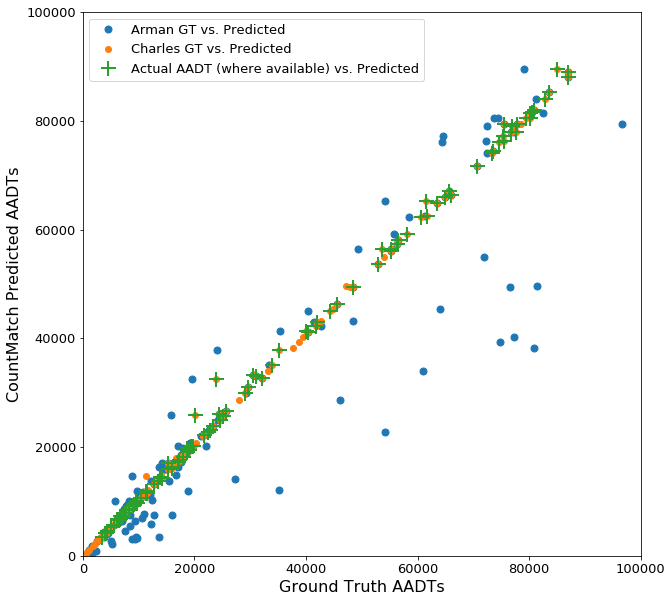

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ptc_validation_aadt['AADT Arman GT'], ptc_validation_aadt['AADT Estimate'],
        color=defaultcolours[0], marker='o', ms=7, ls='None', label='Arman GT vs. Predicted')
ax.plot(ptc_validation_aadt['AADT Charles GT'], ptc_validation_aadt['AADT Estimate'],
        color=defaultcolours[1], marker='o', ls='None', label='Charles GT vs. Predicted')
ax.plot(ptc_validation_aadt.loc[notnulls, 'AADT Actual'],
        ptc_validation_aadt.loc[notnulls, 'AADT Estimate'],
        color=defaultcolours[2], marker='+', ls='None', ms=15, mew=2, label='Actual AADT (where available) vs. Predicted')
ax.set_xlim([0, 100000])
ax.set_ylim([0, 100000])
ax.set_xlabel('Ground Truth AADTs', fontsize=16)
ax.set_ylabel('CountMatch Predicted AADTs', fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=13)
ax.legend(loc=2, prop={'size': 13});

In [14]:
sklm.mean_absolute_error(ptc_validation_aadt.loc[notnulls, 'AADT Estimate'], ptc_validation_aadt.loc[notnulls, 'AADT Actual'])

1003.0450558385081

In [15]:
np.mean(
    np.abs(ptc_validation_aadt.loc[notnulls, 'AADT Actual'] - ptc_validation_aadt.loc[notnulls, 'AADT Estimate']) /
    ptc_validation_aadt.loc[notnulls, 'AADT Actual'])

0.03506338188194463

In [16]:
ptc_validation_aadt.head()

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Arman GT,AADT Charles GT,AADT Actual
0,8540609,1005.155718,30003562,1.024653,2011,1017.752510,1172.934396,1063.497565,NaN
1,-890,70596.744681,-445884,1.017000,2010,71796.909557,70583.480780,70583.480780,70583.480780
2,1003,3342.526882,445280,1.011343,2010,3380.442083,3767.451819,3350.164546,3350.164546
3,1821,5597.157233,6837747,1.025258,2010,5738.530342,5604.686429,5627.793110,5627.793110
4,-104870,17184.369565,-13503833,1.026030,2010,17631.684801,17050.797666,17292.127973,17292.127973


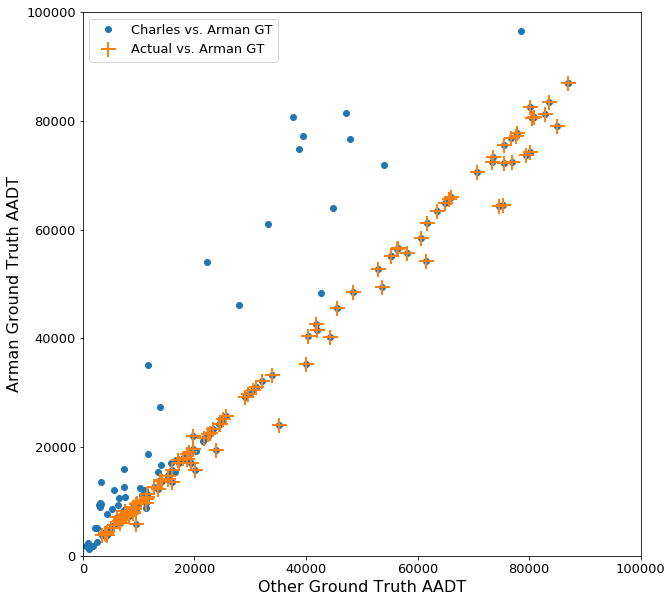

In [17]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(ptc_validation_aadt['AADT Charles GT'], ptc_validation_aadt['AADT Arman GT'],
        color=defaultcolours[0], marker='o', ls='None', label='Charles vs. Arman GT')
ax.plot(ptc_validation_aadt.loc[notnulls, 'AADT Actual'],
        ptc_validation_aadt.loc[notnulls, 'AADT Arman GT'],
        color=defaultcolours[1], marker='+', ls='None', ms=15, mew=2, label='Actual vs. Arman GT')
ax.set_xlim([0, 100000])
ax.set_ylim([0, 100000])
ax.set_xlabel('Other Ground Truth AADT', fontsize=16)
ax.set_ylabel('Arman Ground Truth AADT', fontsize=16)
ax.tick_params(axis='both', which='both', labelsize=13)
ax.legend(loc=2, prop={'size': 13});

In [18]:
ptc_validation_aadt['AC Fractional Deviation'] = np.abs(
    ptc_validation_aadt.loc[:, 'AADT Estimate'] - ptc_validation_aadt.loc[:, 'AADT Arman GT']) / ptc_validation_aadt.loc[:, 'AADT Arman GT']

In [19]:
ptc_validation_aadt.loc[ptc_validation_aadt['Count ID'] > 0, :].sort_values('AC Fractional Deviation', ascending=False).head(15)

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Arman GT,AADT Charles GT,AADT Actual,AC Fractional Deviation
159,14255077,16556.517350,1147201,1.252154,2016,219393.172938,14411.850934,180441.878175,NaN,14.223109
161,20044187,20207.945687,14073981,1.025796,2016,130524.123458,17704.116773,127561.806157,NaN,6.372530
133,444516,1719.845070,444403,1.036634,2015,535.723919,1718.241066,516.309869,NaN,0.688214
50,1147466,24098.348921,14255077,1.350051,2010,32534.010569,19493.519806,23831.603928,23831.603928,0.668965
121,14065128,8700.032143,5439677,1.301841,2012,14670.024758,8801.735137,11400.404732,NaN,0.666720
165,30065733,35308.360140,30007492,1.023809,2017,12018.574913,35105.971256,11671.785038,NaN,0.657649
132,444403,8905.609929,443071,1.036893,2015,3177.419226,8888.472814,3058.469009,NaN,0.642524
43,1147201,20114.472669,14255077,1.290076,2010,25949.201547,15848.164198,20032.989169,20032.989169,0.637363
52,1147544,35456.289562,1147551,1.069437,2010,37918.275729,24125.990570,35230.751580,35230.751580,0.571677
154,8708889,12243.408759,6837747,1.023228,2016,5831.860761,12146.731605,5654.468653,NaN,0.519882


In [20]:
ptc_validation_aadt.loc[ptc_validation_aadt['Count ID'] < 0, :].sort_values('AC Fractional Deviation', ascending=False).head(10)

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Arman GT,AADT Charles GT,AADT Actual,AC Fractional Deviation
147,-445884,64677.762542,-445309,1.009202,2016,115699.322931,64882.736826,115007.638313,NaN,0.783207
63,-9212691,9600.552632,-1145202,1.056820,2010,10146.059601,5810.066570,9503.730778,9503.730778,0.746290
153,-8491741,13659.230284,-1147201,1.054257,2016,3490.175961,13632.425063,3304.059024,NaN,0.743980
162,-13503206,9458.558304,-8171,1.042921,2017,3069.949485,9397.684791,2924.662011,NaN,0.673329
163,-13503207,9703.127660,-8171,1.042879,2017,3306.457249,9640.698061,3150.109140,NaN,0.657031
164,-13503251,9573.336879,-8171,1.042879,2017,3510.362251,9513.119713,3344.856641,NaN,0.630998
130,-442915,2150.949640,-444637,1.030760,2015,931.944018,2365.653971,903.418254,NaN,0.606052
142,-30003565,54113.130909,-14659244,1.026642,2015,22829.232551,54092.216417,22228.210208,NaN,0.577957
140,-20140757,4755.815182,-441170,1.008864,2015,2236.160004,5149.109865,2214.760749,NaN,0.565719
139,-12334937,15968.133562,-1146997,1.019588,2015,7525.692198,16004.157421,7397.762979,NaN,0.529766


Observations:
- For stations where there's 2010 AADT data, my MAPE is around 3%, which is excellent, and to be expected considering that a). there's probably a very closely correlated nearby PTC and b). `D_ij` is like 3% and growth rates are at a few percent a year regardless if you use the citywide mean growth or the growth per PTC.
    - There's a good case that all of CountMatch is a highly overcomplicated AADT rescaler and we should just switch to GPR.
- Arman's ground truth estimate, which uses a weighted mean across PTC AADTs for multiple years, is often a poor estimate for the true AADT (my way of estimating the GT hits the AADT exactly when data exists, and does a simple growth of the closest year AADT when it doesn't).
- This difference between GT estimates accounts for most of the scatter we saw in the initial validation test from `CountMatchDev1-Prototype.ipynb`.
- TEPS does worse for 2010-positive than 2010-negative.

## Read in TEPS validation data

In [21]:
# Read in some old results from 
teps_2010pos = pd.read_csv(('/mnt/c/Users/czhu5/Documents/VolumeModel/'
                            'TEPS-dev/PRTCS/output_PRTCS2010positive/validation_2010.txt'),
                           names=['centreline_id', 'arman_gt', 'pred'])
teps_2010neg = pd.read_csv(('/mnt/c/Users/czhu5/Documents/VolumeModel/'
                            'TEPS-dev/PRTCS/output_PRTCS2010negative/validation_2010.txt'),
                           names=['centreline_id', 'arman_gt', 'pred'])

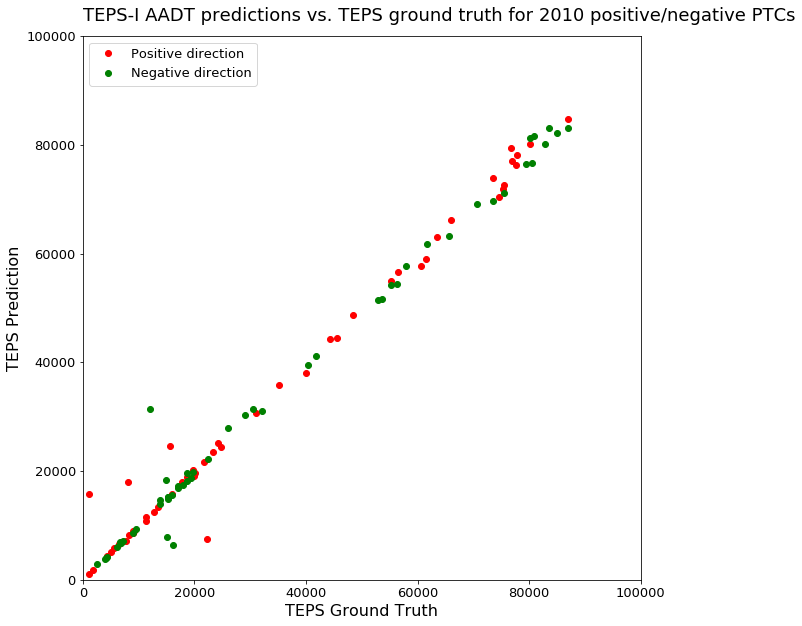

In [22]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(teps_2010pos['arman_gt'], teps_2010pos['pred'],
        color='r', marker='o', ls='None', label='Positive direction')
ax.plot(teps_2010neg['arman_gt'], teps_2010neg['pred'],
        color='g', marker='o', ls='None', label='Negative direction')
ax.set_xlim([0, 100000])
ax.set_ylim([0, 100000])
ax.set_xlabel('TEPS Ground Truth', fontsize=16)
ax.set_ylabel('TEPS Prediction', fontsize=16)
ax.set_title('TEPS-I AADT predictions vs. TEPS ground truth for 2010 positive/negative PTCs', fontsize=18, loc='left', pad=15)
ax.tick_params(axis='both', which='both', labelsize=13)
ax.legend(loc=2, prop={'size': 13});

In [23]:
teps_2010neg['abs. frac. err.'] = np.abs(teps_2010neg['pred'] - teps_2010neg['arman_gt']) / teps_2010neg['arman_gt']
teps_2010pos['abs. frac. err.'] = np.abs(teps_2010pos['pred'] - teps_2010pos['arman_gt']) / teps_2010pos['arman_gt']

In [24]:
teps_2010neg.sort_values('abs. frac. err.', ascending=False).head(5)

,centreline_id,arman_gt,pred,abs. frac. err.
4,442161,12119.935550,31385.405780,1.589569
48,30073545,16132.470520,6312.287959,0.608722
26,6436449,15079.177800,7823.046412,0.481202
41,20050591,14990.636340,18293.174960,0.220307
1,106797,2524.101245,2990.290806,0.184695


In [25]:
teps_2010pos.sort_values('abs. frac. err.', ascending=False).head(5)

,centreline_id,arman_gt,pred,abs. frac. err.
2,106898,1078.342068,15750.534210,13.606250
9,446012,8042.166724,17935.500110,1.230183
44,30019302,22322.260710,7440.350803,0.666685
41,20230203,15648.479800,24546.358170,0.568610
39,20043629,7654.251995,7224.722261,0.056116


# -443975

Centreline ID 443975 negative direction exists in Arman's results and mine.  My results are:

In [26]:
ptc_validation_aadt[ptc_validation_aadt['Count ID'] == -443975]

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Arman GT,AADT Charles GT,AADT Actual,AC Fractional Deviation
13,-443975,85027.156352,-442915,1.05314,2010,89545.469062,78977.804873,85009.788625,85009.788625,0.133805


Arman's are

In [27]:
teps_2010neg[teps_2010neg['centreline_id'] == 443975]

,centreline_id,arman_gt,pred,abs. frac. err.
6,443975,84991.82872,82183.87402,0.033038


There's major discrepancies even between my `'AADT Arman GT'` and what TEPS actually reports.  Note that `8.4992e+04` is the actual AADT from Arman's raw data, and differs by less than a percent than my `'AADT Actual'`

In [28]:
rdr.ptcs[-443975].tc_mse.groupby('PTC ID')['AADT'].mean()

PTC ID
-445309    78977.804873
-444637    78977.804873
-443987    78977.804873
-442915    78977.804873
-442447    78977.804873
Name: AADT, dtype: float64

The reason for this is there's only 2010 data in TEPS, but both 2010 and 2015 data exist for CountMatch.  The Matlab command `R_AADTij(R_AADTij(:,2)==v1(j),3)` doesn't account for changing years, so would have a much greater error.

Just to check, do we match to the same neighbour?

In [29]:
def get_actual_neighbours(tc, rptcs):
    """Since bidirectional neighbours are stored in nb.data,
    show only the five nearest same-direction links."""
    neighbours, distances = nb.get_neighbours(tc.centreline_id)
    return [rptcs[n].centreline_id for n in
            [tc.direction * nbrs for nbrs in neighbours]
            if n in rptcs.keys()][:5]

In [30]:
get_actual_neighbours(rdr.ptcs[-443975], rdr.ptcs)

[443987, 444637, 442915, 445309, 442447]

In Matlab,

```matlab
v1(j); % this PTC
curr_mses = MSE(MSE(:,2)==v1(j),:); % MSE table
iDoMs(curr_mses(iminMSE, 1)) % nearest PTC matched with this PTC
```

Retrieved `442447`

So not quite, but this appears to be because I have more PTCs.

## -442161

In [31]:
ptc_validation_aadt[ptc_validation_aadt['Count ID'] == -442161]

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Arman GT,AADT Charles GT,AADT Actual,AC Fractional Deviation
9,-442161,33794.317901,-11129605,1.038739,2010,35103.491476,33351.082367,33880.909914,33880.909914,0.052544


In [32]:
teps_2010neg[teps_2010neg['centreline_id'] == 442161]

,centreline_id,arman_gt,pred,abs. frac. err.
4,442161,12119.93555,31385.40578,1.589569


In [33]:
rdr.ptcs[-442161].growth_factor**(2010-2016)

1.1026077342206893

In [34]:
rdr.ptcs[-442161].data['AADT']

,AADT
Year,
2010,33880.909914
2012,32795.535036


The problem here appears to be TEPS's AADT is wrong - `AADTs(AADTs(:, 3) == v1(j), 4)` correctly returns `3.2755e+04`, but `unique(DoM_PTC(DoM_PTC(:,5)==v1(j),15))` returns `1.2120e+04`.  This is set in `SEL_ratio`, and I have very little interest in following up why this happened, so we'll chalk that up to bad accounting.

## -30073545


In [35]:
ptc_validation_aadt[ptc_validation_aadt['Count ID'] == -30073545]

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Arman GT,AADT Charles GT,AADT Actual,AC Fractional Deviation
102,-30073545,8182.621118,-20050591,1.045307,2010,8553.354613,7400.50154,8245.026432,8245.026432,0.15578


In [36]:
teps_2010neg[teps_2010neg['centreline_id'] == 30073545]

,centreline_id,arman_gt,pred,abs. frac. err.
48,30073545,16132.47052,6312.287959,0.608722


In [37]:
rdr.ptcs[-30073545].tc_mse.groupby('Year')['AADT'].mean()

Year
2010    8245.026432
2012    6456.275793
Name: AADT, dtype: float64

In [38]:
rdr.ptcs[-30073545].tc_mse.groupby('PTC ID')['AADT'].mean()

PTC ID
-20050591    7400.50154
-13503833    7400.50154
-9637988     7400.50154
-106797      7400.50154
-104870      7400.50154
Name: AADT, dtype: float64

Here again, `AADTs(AADTs(:, 3) == v1(j), 4)` returns an incorrect but reasonable `6.4541e+03`, but `unique(DoM_PTC(DoM_PTC(:,5)==v1(j),15))` gives `1.6132e+04`, wherever that number's from.

## 1147544

In [39]:
ptc_validation_aadt[ptc_validation_aadt['Count ID'] == 1147544]

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Arman GT,AADT Charles GT,AADT Actual,AC Fractional Deviation
52,1147544,35456.289562,1147551,1.069437,2010,37918.275729,24125.99057,35230.75158,35230.75158,0.571677


In [40]:
teps_2010pos[teps_2010pos['centreline_id'] == 1147544]

,centreline_id,arman_gt,pred,abs. frac. err.
25,1147544,35228.80634,35746.97133,0.014709


In [41]:
rdr.ptcs[1147544].tc_mse.groupby('Year')['AADT'].mean()

Year
2010    35230.751580
2016    18812.643682
2017    18307.355537
Name: AADT, dtype: float64

Here's another case where the TEPS ground truth is fine because it only has access to one year's worth of PTC data, but because we have 3, we get a much bigger error.

## What about major outliers comparing to Charles's ground truth?

In [42]:
ptc_validation_aadt['CG Fractional Deviation'] = np.abs(
    ptc_validation_aadt.loc[:, 'AADT Estimate'] - ptc_validation_aadt.loc[:, 'AADT Charles GT']) / ptc_validation_aadt.loc[:, 'AADT Charles GT']

In [43]:
ptc_validation_aadt.loc[ptc_validation_aadt['Count ID'] > 0, :].sort_values('CG Fractional Deviation', ascending=False).head(5)

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Arman GT,AADT Charles GT,AADT Actual,AC Fractional Deviation,CG Fractional Deviation
50,1147466,24098.348921,14255077,1.350051,2010,32534.010569,19493.519806,23831.603928,23831.603928,0.668965,0.365162
43,1147201,20114.472669,14255077,1.290076,2010,25949.201547,15848.164198,20032.989169,20032.989169,0.637363,0.295323
121,14065128,8700.032143,5439677,1.301841,2012,14670.024758,8801.735137,11400.404732,NaN,0.666720,0.286799
159,14255077,16556.517350,1147201,1.252154,2016,219393.172938,14411.850934,180441.878175,NaN,14.223109,0.215866
125,5439677,4340.380952,6248089,1.095253,2013,4560.757767,4341.678352,4165.358554,NaN,0.050460,0.094926


In [44]:
ptc_validation_aadt.loc[ptc_validation_aadt['Count ID'] < 0, :].sort_values('CG Fractional Deviation', ascending=False).head(5)

,Count ID,Mean Daily Count,PTC ID,D_ij,Closest Year,AADT Estimate,AADT Arman GT,AADT Charles GT,AADT Actual,AC Fractional Deviation,CG Fractional Deviation
31,-1146358,6153.674419,-12336156,1.114130,2010,6855.995607,7099.441981,6119.285824,6119.285824,0.034291,0.120391
107,-30087988,15290.778146,-12336156,1.112517,2010,17011.249243,14162.958910,15255.520320,15255.520320,0.201108,0.115088
94,-30021784,6855.003584,-1145202,1.060882,2010,7272.352294,6662.478467,6662.478467,6662.478467,0.091539,0.091539
46,-1147347,30707.932660,-13515818,1.084328,2010,33297.457561,30578.572598,30578.572598,30578.572598,0.088915,0.088915
63,-9212691,9600.552632,-1145202,1.056820,2010,10146.059601,5810.066570,9503.730778,9503.730778,0.746290,0.067587


It looks like these are due to large `D_ij`.  We should investigate those separately.

## Conclusions

- The largest differences between my estimates and TEPS are due to TEPS's ground truth AADT formula, which leads to large errors when applied to multi-year PTC data.  It works for TEPS because so many PTCs only have one year's worth of data there.
- Some large errors in TEPS according to its own validation script are from improper attribution of AADT, probably somewhere in `SEL_estimate.m`.
- We should stop comparing to TEPS and rewrite CountMatch according to our own understanding of Bagheri.